In [12]:
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import curvedsky
import orphics
from orphics import maps, cosmology
from math import pi

import plancklens
from plancklens import utils
from plancklens import nhl
from plancklens.n1 import n1
from plancklens import qest, qecl, qresp

import pandas as pd
%matplotlib inline

In [100]:
exps_config = {
    'CMB_S4': {
        'nlev_t': 1,
        'nlev_p':2**0.5,
        'beam_arcmin': 1.4
    }
}


nlev_t = 1
nlev_p = 2**0.5
beam_arcmin = 1.4
lmax = 3000
ellmin = 30
ellmax = 3000

# nlev_t = 0
# nlev_p = 0
# beam_arcmin = 1.4
# lmax = 3000
# ellmin = 30
# ellmax = 3000



ls = np.arange(lmax+1)
ells = np.arange(ellmax+1)

In [101]:
theory = cosmology.default_theory()
cltt, clee, clbb = theory.lCl('TT', ls), theory.lCl('EE', ls), theory.lCl('BB', ls)
clte = theory.lCl('TE', ls)

A_cb_index = '07'
main_path = '/global/cscratch1/sd/hongbo/lens_rot_bias/'
cls_path = '/global/cscratch1/sd/hongbo/lens_rot_bias/inputPs'

In [102]:
claa = np.loadtxt(cls_path + '/claa_A1e-%s.txt' %A_cb_index)[:,1]

In [103]:
clpp = np.loadtxt(cls_path + '/cosmo2017_10K_acc3_lenspotentialCls.dat', \
                  usecols=(5), unpack=True)
fac = (ls*(ls+1))**2/(2*pi)
fac[0] = 1
clpp = np.concatenate(([1,1], clpp))[ls]/fac

In [104]:
nltt = (nlev_t*pi/180/60)**2/maps.gauss_beam(ls, beam_arcmin)**2
nlee = (nlev_p*pi/180/60)**2/maps.gauss_beam(ls, beam_arcmin)**2
nlbb = nlee

ocltt = cltt + nltt
oclee = clee + nlee
oclbb = clbb + nlbb
oclee[0], oclee[1], oclbb[0], oclbb[1] = 1, 1, 1, 1

In [105]:
nl_eb = curvedsky.norm_quad.qeb('lens', ellmax, ellmin, ellmax, clee[:ellmax+1],\
                                        oclee[:ellmax+1], oclbb[:ellmax+1], lfac='')[0]
Al_eb = nl_eb * ells**2

In [106]:
import solenspipe
from falafel import qe,utils
ucls,tcls = utils.get_theory_dicts(grad=True)

In [107]:
bh,ells,Als,R_src_tt,Nl_g,Nl_c,Nl_g_bh = solenspipe.get_tempura_norms('EB',
                                                                'EB',ucls,tcls, \
                                                                ellmin,ellmax,ellmax)

/global/u2/h/hongbo/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


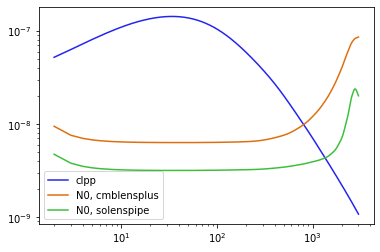

In [108]:
plt.plot(ls[2:], (fac*clpp)[2:], label='clpp')
plt.plot(ls[2:], (fac*nl_eb)[2:], label='N0, cmblensplus')
# for noiseless map
plt.plot(ls[2:], (fac*(4*Nl_g/(ls*(ls+1))**2))[2:], label='N0, solenspipe')
plt.xscale('log')
plt.yscale('log')
plt.legend()

# firstly calculate unormalized uN1aa

In [109]:
ftl = 1/ocltt[:ellmax+1]
fel = 1/oclee[:ellmax+1]
fbl = 1/oclbb[:ellmax+1]

ftl[:ellmin] *= 0.
fel[:ellmin] *= 0.
fbl[:ellmin] *= 0.

In [110]:
#---- N1 lensing bias library:
n1_dd = n1.library_n1(main_path+'/notebooks_new/',cltt,clte,clee)

In [111]:
n1aa = n1_dd.get_n1('peb', 'r', claa, ftl, fel, fbl, ellmax)

n1: doing L 1 kA peb kB peb kind r
n1: doing L 2 kA peb kB peb kind r
n1: doing L 3 kA peb kB peb kind r
n1: doing L 4 kA peb kB peb kind r
n1: doing L 5 kA peb kB peb kind r
n1: doing L 6 kA peb kB peb kind r
n1: doing L 7 kA peb kB peb kind r
n1: doing L 8 kA peb kB peb kind r
n1: doing L 9 kA peb kB peb kind r
n1: doing L 10 kA peb kB peb kind r
n1: doing L 21 kA peb kB peb kind r
n1: doing L 41 kA peb kB peb kind r
n1: doing L 61 kA peb kB peb kind r
n1: doing L 81 kA peb kB peb kind r
n1: doing L 101 kA peb kB peb kind r
n1: doing L 121 kA peb kB peb kind r
n1: doing L 141 kA peb kB peb kind r
n1: doing L 161 kA peb kB peb kind r
n1: doing L 181 kA peb kB peb kind r
n1: doing L 201 kA peb kB peb kind r
n1: doing L 221 kA peb kB peb kind r
n1: doing L 241 kA peb kB peb kind r
n1: doing L 261 kA peb kB peb kind r
n1: doing L 281 kA peb kB peb kind r
n1: doing L 301 kA peb kB peb kind r
n1: doing L 321 kA peb kB peb kind r
n1: doing L 341 kA peb kB peb kind r
n1: doing L 361 kA peb k

In [112]:
Ls = np.concatenate([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], np.arange(1, ellmax + 1)[::20], [ellmax]])

In [113]:
# Then calcute the correct Al_eb

In [114]:
data = pd.read_csv(main_path + 'notebooks/CMB_S4_30_3000_n.csv')
bias = ((data['EB_rot_reckap_x_reckap']-data['EB_reckap_x_reckap'])-(data['EB_rot_rdn0']-data['EB_rdn0']))/\
                 data['EB_inkap_x_inkap']

/global/u2/h/hongbo/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


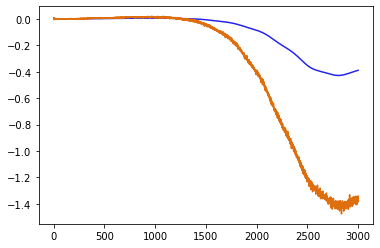

In [115]:
plt.plot(Ls, 100*((Al_eb/ells**2)**2)[Ls]*n1aa[Ls]/clpp[Ls])
plt.plot(data['L'], bias)